In [1]:
from __future__ import annotations

from ast import literal_eval
import sys; sys.path.append("../utils")
import _confusion_matrix

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [3]:
RAW_DATA_FILES = "../../data/reddit_ell_eng_raw_pos{}.csv"
RAW_DATA_MAXLEN = ['none', '300', '200']

In [4]:
models_df = pd.DataFrame({
    'model': [
        'LSVM', 
        'LogReg'
    ],
    'base': [
        SGDClassifier(loss='hinge'),
        SGDClassifier(loss='log_loss'), # 'log' is deprecated in 1.1
    ],
    'word_params': [
        {
            'cxf__words__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
        },
        {
            'cxf__words__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
        },
    ],
    'char_params': [
        {
            'cxf__chars__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
        },
        {
            'cxf__chars__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
        },
    ],
    'pos_tags_params': [
        {
            'cxf__postg__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
        },
        {
            'cxf__postg__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
        },
    ],
})

In [5]:
all_results = pd.DataFrame()

(7895, 2) (2029, 2) (7895,) (2029,)

======================================LSVM====================================== ======================================none======================================
-------------------------------------WORDS--------------------------------------
Fitting 10 folds for each of 5 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.82      0.67      0.73      1041
           1       0.71      0.84      0.77       988

    accuracy                           0.75      2029
   macro avg       0.76      0.75      0.75      2029
weighted avg       0.76      0.75      0.75      2029


Saved confusion matrix: ../results/figures/sgd_0.751_words_20221228_1120.svg
-------------------------------------CHARS--------------------------------------
Fitting 10 folds for each of 5 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1041
   

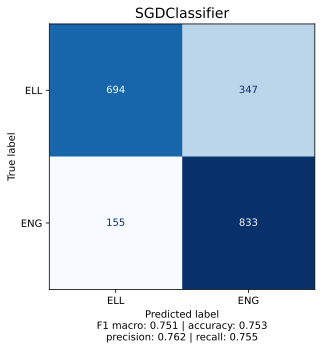

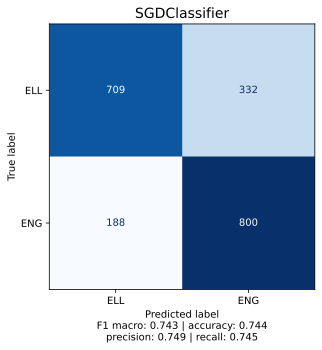

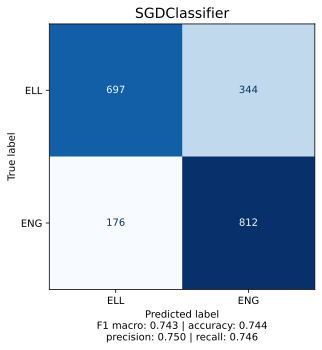

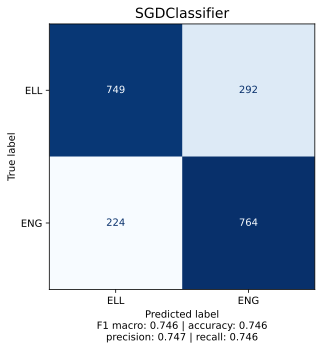

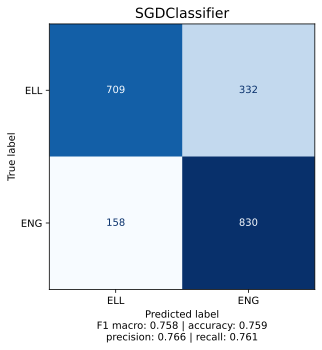

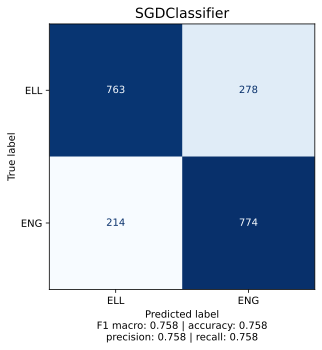

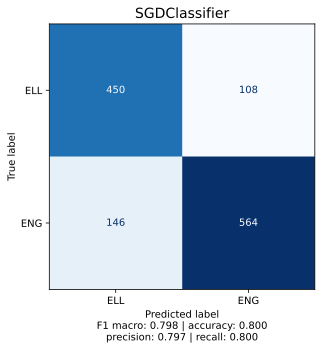

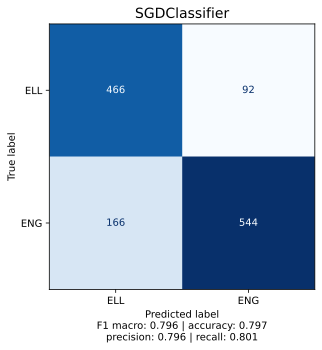

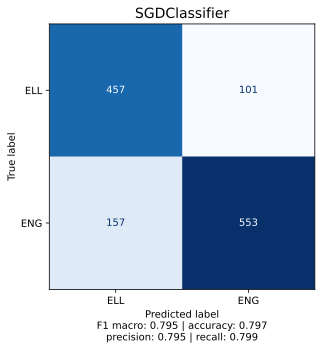

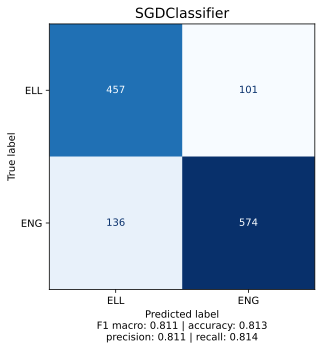

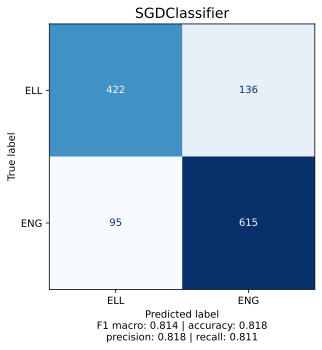

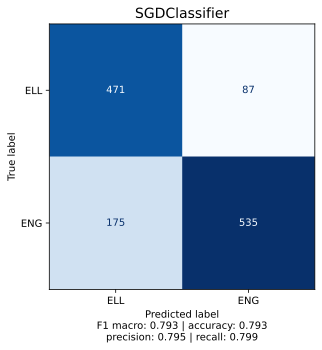

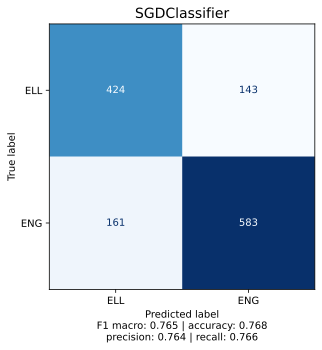

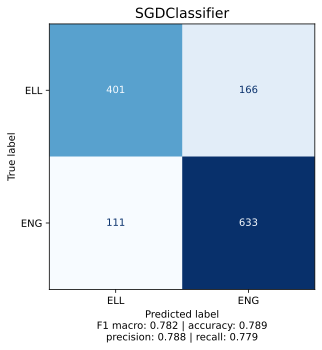

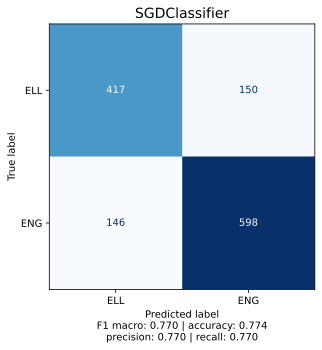

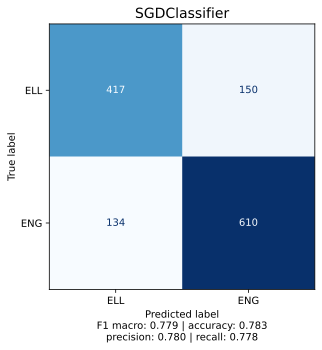

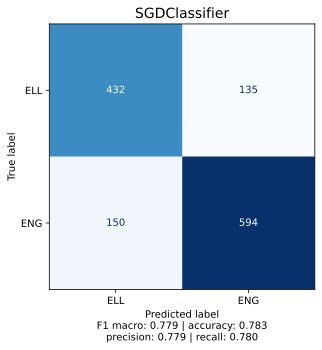

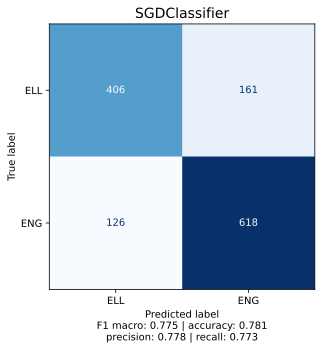

In [6]:
for maxlen in RAW_DATA_MAXLEN:
    df = pd.read_csv(RAW_DATA_FILES.format(f"_{maxlen}" if maxlen != 'none' else ''),
                                           encoding='utf-8')

    df, labels = encode_labels(df, 'label')

    X = df[['text', 'pos_tags']]
    y = df['label']

    gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups=df['user_id']))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, end="\n\n")


    # run cross-validation, each time using only one of the three features
    word_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
    char_vect = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
    post_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))

    for i, row in models_df.iterrows():
        model = row['model']
        base = row['base']
        word_params = row['word_params']
        char_params = row['char_params']
        pos_tags_params = row['pos_tags_params']

        cxf = ColumnTransformer(
            [
                ('words', word_vect, 'text'),
                ('chars', char_vect, 'text'),
                ('postg', post_vect, 'pos_tags'),
            ],
            remainder='drop',
        )

        pipe = Pipeline([
            ('cxf', cxf),
            ('clf', base),
        ])


        print(f"{model:=^80} {maxlen:=^80}")
        print("WORDS".center(80, "-"))
        word_grid = GridSearchCV(pipe, word_params, cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
        word_grid.fit(X_train, y_train)
        y_pred = word_grid.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")
        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment='words')
        word_results = pd.DataFrame(word_grid.cv_results_)
        word_results['model'] = model
        word_results['maxlen'] = maxlen
        word_results['feature'] = 'words'
        all_results = pd.concat([all_results, word_results])


        print("CHARS".center(80, "-"))
        char_grid = GridSearchCV(pipe, char_params, cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
        char_grid.fit(X_train, y_train)
        y_pred = char_grid.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")
        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment='chars')
        word_results = pd.DataFrame(char_grid.cv_results_)
        word_results['model'] = model
        word_results['maxlen'] = maxlen
        word_results['feature'] = 'chars'
        all_results = pd.concat([all_results, word_results])


        print("POS tags".center(80, "-"))
        post_grid = GridSearchCV(pipe, pos_tags_params, cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
        post_grid.fit(X_train, y_train)
        y_pred = post_grid.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")
        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment='pos_tags')
        word_results = pd.DataFrame(post_grid.cv_results_)
        word_results['model'] = model
        word_results['maxlen'] = maxlen
        word_results['feature'] = 'pos_tags'
        all_results = pd.concat([all_results, word_results])

        print(f"{model} done", end="\n\n")

In [7]:
# sort values in params column
all_results['params'] = all_results['params'].apply(lambda x: str(x))
all_results = all_results.sort_values(by='params')
all_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cxf__words__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,model,maxlen,feature,param_cxf__chars__ngram_range,param_cxf__postg__ngram_range
0,2.855809,0.191483,0.299759,0.023479,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.756846,0.719177,0.811517,0.745427,...,0.768439,0.745205,0.768338,0.030002,5,LogReg,300,chars,"(1, 1)",NaN
0,2.679685,0.095431,0.282022,0.023596,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.808848,0.758686,0.799619,0.759719,...,0.785283,0.812126,0.776402,0.024830,5,LogReg,200,chars,"(1, 1)",NaN
0,2.568165,0.153484,0.271125,0.020437,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.725483,0.772393,0.718575,0.781601,...,0.851467,0.827016,0.770808,0.050333,2,LSVM,none,chars,"(1, 1)",NaN
0,2.431582,0.196393,0.262724,0.026324,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.690082,0.778448,0.702352,0.782581,...,0.860581,0.818758,0.769604,0.062220,5,LogReg,none,chars,"(1, 1)",NaN
0,3.072597,0.211155,0.298274,0.033031,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.752545,0.728300,0.809935,0.714285,...,0.759073,0.751783,0.763342,0.030924,5,LSVM,300,chars,"(1, 1)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,14.173893,1.237472,0.471069,0.096202,"(1, 5)","{'cxf__words__ngram_range': (1, 5)}",0.733526,0.782005,0.748191,0.779745,...,0.854222,0.814848,0.777287,0.048156,1,LSVM,none,words,NaN,NaN
4,18.384992,1.008100,0.639577,0.107647,"(1, 5)","{'cxf__words__ngram_range': (1, 5)}",0.766336,0.739850,0.824848,0.742824,...,0.787921,0.748519,0.773741,0.027464,3,LSVM,300,words,NaN,NaN
4,15.974428,1.320375,0.499263,0.089538,"(1, 5)","{'cxf__words__ngram_range': (1, 5)}",0.794844,0.778381,0.824931,0.761046,...,0.790939,0.820233,0.778969,0.027188,4,LSVM,200,words,NaN,NaN
4,14.586731,1.162335,0.496014,0.084632,"(1, 5)","{'cxf__words__ngram_range': (1, 5)}",0.781645,0.734418,0.806422,0.742382,...,0.758390,0.817421,0.762573,0.029946,5,LogReg,200,words,NaN,NaN


In [19]:
all_results = all_results.reset_index(drop=True)
all_results.to_csv('all_results_lsvm_logreg_single_feats.csv', index=False, encoding='utf-8')

In [115]:
import pandas as pd
from ast import literal_eval
from IPython.display import display as ipy_display

with pd.option_context('display.max_rows', None):
    all_res = all_results[['model', 'maxlen', 'feature', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    all_res['feature'] = all_res['feature'].str.replace('words', 'Words').str.replace('chars', 'Characters').str.replace('pos_tags', 'POS')
    all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
    all_res['params'] = all_res['params'].apply(lambda x: "".join("n = " + str(val).removeprefix('(').removesuffix(')')
                                                                  for val in x.values()))
    all_res = all_res.rename(columns={'params': 'n_grams', 'mean_test_score': 'F1-score', 'std_test_score': 'std',})
    all_res = all_res.sort_values(by=['model', 'maxlen', 'feature', 'n_grams'])
    all_res = all_res.groupby(['model', 'maxlen', 'feature', 'n_grams']).agg({'F1-score': 'mean', 'std': 'mean'})
    all_res = all_res.unstack('model')  # move model to columns and group by model
    all_res = all_res.swaplevel(axis=1).sort_index(axis=1)  # swap F1-score and std columns with model

    ipy_display(all_res)

all_res.to_latex('all_results_lsvm_logreg_single_feats.tex', encoding='utf-8')

C:\Users\dimboump\AppData\Local\Temp\ipykernel_2296\1642401895.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['feature'] = all_res['feature'].str.replace('words', 'Words').str.replace('chars', 'Characters').str.replace('pos_tags', 'POS')
C:\Users\dimboump\AppData\Local\Temp\ipykernel_2296\1642401895.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
C:\Users\dimboump\AppData\Local\Temp\ipykernel_2296\1642401895.py:9: Settin

model                           LSVM              LogReg          
                            F1-score       std  F1-score       std
maxlen feature    n_grams                                         
200    Characters n = 1, 1  0.767702  0.025151  0.776402  0.024830
                  n = 1, 2  0.775488  0.023755  0.779492  0.024261
                  n = 1, 3  0.775152  0.023321  0.782263  0.024030
                  n = 1, 4  0.773861  0.027301  0.786204  0.027782
                  n = 1, 5  0.774530  0.022233  0.781660  0.024661
       POS        n = 1, 1  0.774035  0.027871  0.774009  0.026165
                  n = 1, 2  0.768710  0.030867  0.775591  0.030674
                  n = 1, 3  0.768735  0.033411  0.779069  0.027577
                  n = 1, 4  0.765455  0.032099  0.779564  0.028390
                  n = 1, 5  0.767813  0.026895  0.780464  0.032749
       Words      n = 1, 1  0.773023  0.025804  0.778952  0.028880
                  n = 1, 2  0.780928  0.027554  0.776027  0.031392
                  n = 1, 3  0.781998  0.026896  0.776267  0.030232
                  n = 1, 4  0.783310  0.028345  0.766888  0.032431
                  n = 1, 5  0.778969  0.027188  0.762573  0.029946
300    Characters n = 1, 1  0.763342  0.030924  0.768338  0.030002
                  n = 1, 2  0.766767  0.027822  0.773281  0.034321
                  n = 1, 3  0.771384  0.028097  0.772702  0.026769
                  n = 1, 4  0.769881  0.028420  0.774774  0.027326
                  n = 1, 5  0.768674  0.026666  0.774116  0.036223
       POS        n = 1, 1  0.770206  0.032214  0.768813  0.027884
                  n = 1, 2  0.760301  0.035370  0.770949  0.030640
                  n = 1, 3  0.759343  0.035130  0.770939  0.032147
                  n = 1, 4  0.759183  0.031938  0.773704  0.031835
                  n = 1, 5  0.761938  0.033669  0.776107  0.032608
       Words      n = 1, 1  0.770400  0.028499  0.773076  0.028434
                  n = 1, 2  0.772828  0.025055  0.772493  0.032897
                  n = 1, 3  0.774548  0.024733  0.765874  0.037868
                  n = 1, 4  0.778504  0.027260  0.760484  0.033769
                  n = 1, 5  0.773741  0.027464  0.762961  0.036875
none   Characters n = 1, 1  0.770808  0.050333  0.769604  0.062220
                  n = 1, 2  0.772521  0.049833  0.774725  0.052501
                  n = 1, 3  0.768064  0.045349  0.779691  0.049781
                  n = 1, 4  0.769167  0.046628  0.780277  0.050777
                  n = 1, 5  0.765865  0.046301  0.777984  0.051720
       POS        n = 1, 1  0.768421  0.047690  0.773917  0.048415
                  n = 1, 2  0.763963  0.043064  0.776445  0.052747
                  n = 1, 3  0.762714  0.043811  0.774246  0.052301
                  n = 1, 4  0.761585  0.040196  0.774300  0.050394
                  n = 1, 5  0.764563  0.045198  0.777925  0.051743
       Words      n = 1, 1  0.765265  0.048926  0.777475  0.049262
                  n = 1, 2  0.776876  0.047088  0.772450  0.052114
                  n = 1, 3  0.777085  0.047998  0.767211  0.048499
                  n = 1, 4  0.776066  0.047676  0.759074  0.048723
                  n = 1, 5  0.777287  0.048156  0.755464  0.044807

C:\Users\dimboump\AppData\Local\Temp\ipykernel_2296\1642401895.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  all_res.to_latex('all_results_lsvm_logreg_single_feats.tex', encoding='utf-8')


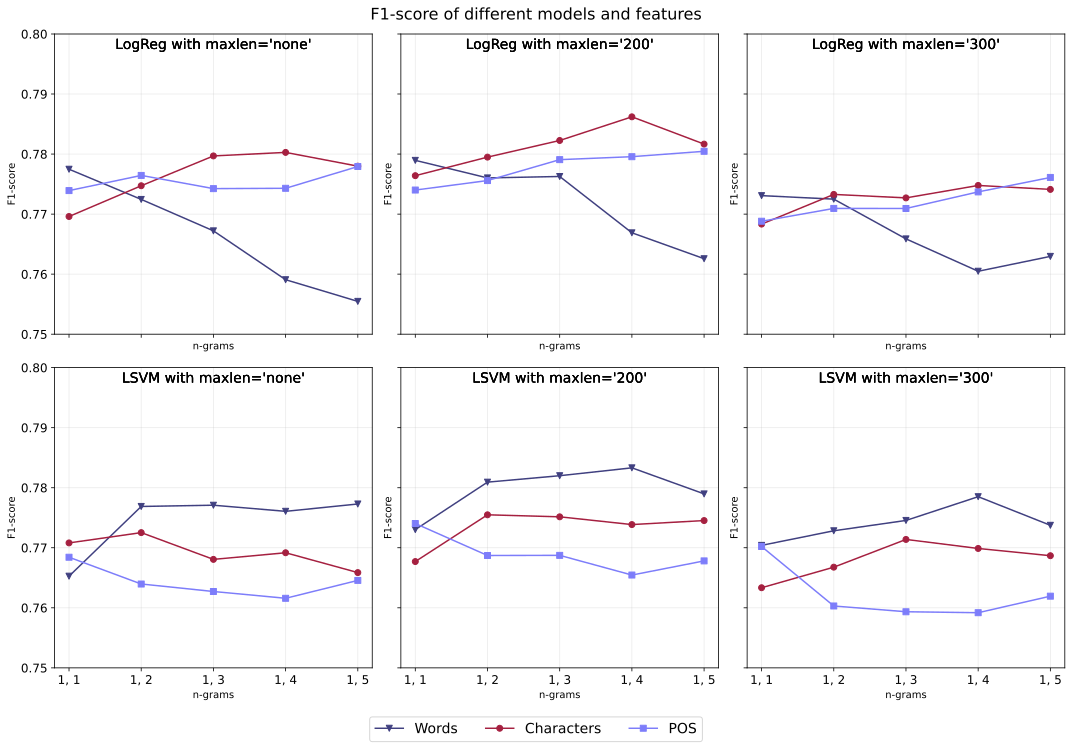

In [159]:
from matplotlib.pyplot import Line2D

markers = {
    "characters": "o", 
    "pos": "s", 
    "words": "v"
}

colors = {
    "characters": "#a52040", 
    "words": "#404080",
    "pos": "#7d7dfa"
}

# make subplots with 2 rows and 3 columns. The rows are for the different models, and the columns for the different features
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)

for i, model in enumerate(['LogReg', 'LSVM']):
    for j, maxlen in enumerate(['none', '200', '300']):
        for k, feature in enumerate(['Words', 'Characters', 'POS']):
            df = all_res.loc[(maxlen, feature), model]
            mean = df['F1-score']
            std = df['std']
            n_grams = df.index
            axes[i, j].plot(n_grams, mean, color=colors[feature.lower()], marker=markers[feature.lower()], label=feature)
            axes[i, j].text(0.5, 0.95, f'{model} with {maxlen=}', transform=axes[i, j].transAxes, ha='center', fontsize=14)
            axes[i, j].set_xticks(n_grams)
            axes[i, j].set_xticklabels([n_gram.replace('n = ', '') for n_gram in n_grams])
            axes[i, j].set_ylim(0.75, 0.8)
            axes[i, j].tick_params(axis='x', labelsize=12)
            axes[i, j].tick_params(axis='y', labelsize=12)
            axes[i, j].set_xlabel('n-grams')
            axes[i, j].set_ylabel('F1-score')
            axes[i, j].grid(zorder=0, alpha=0.25)

fig.suptitle('F1-score of different models and features', fontsize=16)
fig.legend(handles=[Line2D([0], [0], color=colors['words'], marker=markers['words'], label='Words'),
                    Line2D([0], [0], color=colors['characters'], marker=markers['characters'], label='Characters'),
                    Line2D([0], [0], color=colors['pos'], marker=markers['pos'], label='POS')],
              loc='lower center', ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.05))

fig.subplots_adjust(bottom=0.5) # fix legend overlapping with subplots
fig.subplots_adjust(top=1.0) # set the spacing between the subplots and the title
fig.tight_layout() # set the spacing between the subplots
